<center><h1>Retrieval Augmented Generation (RAG) with LangChain</h1></center>

---
# 1. Building RAG Applications with LangChain

---

# Loading Documents for RAG with LangChain

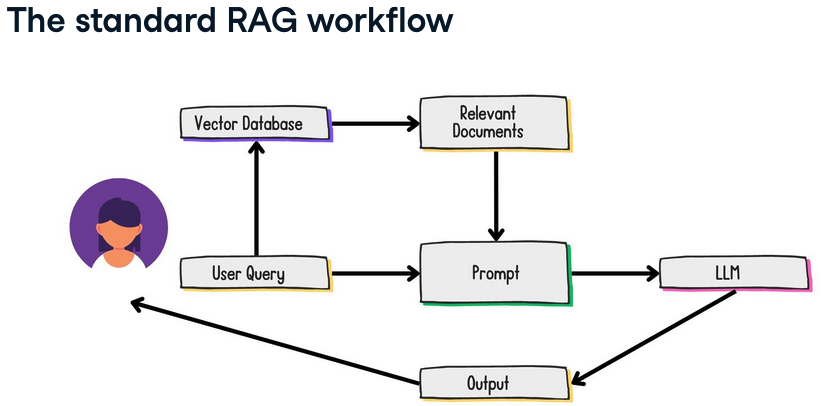

RAG provides extra context for more informed LLM responses. This method is commonly used to provide more relevant answers to users based on company's external proprietary data. 

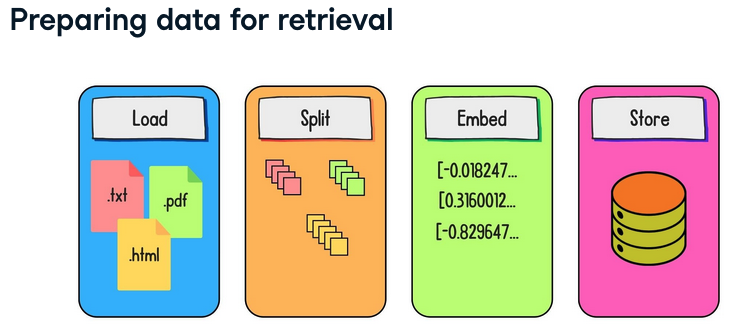



# Text splitting, embeddings, and vector storage

The same content has been covered in `Developing LLM Applications in LangChain.ipynb`

# Building an LCEL retrieval chain

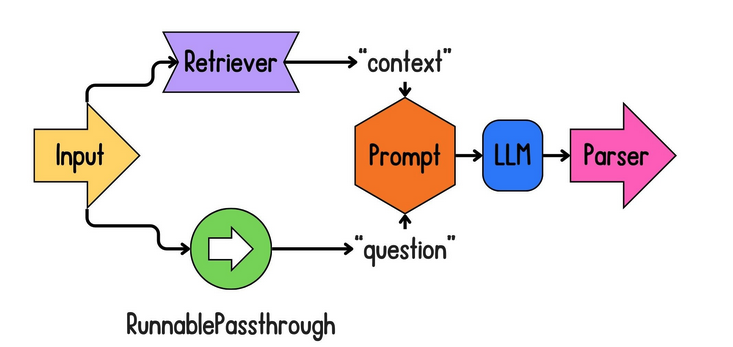

**Instantiating a retriever**

```python
vector_store = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model
)

retriever = vector_store.as_retriever(
    search_type='similarity',
    search_kwargs={"k": 2}
)
```

**Creating a prompt template**

```python
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template("""
Use the following pieces of context to answer the question at the end. 
If you don't know the answer, say that you don't know.
Context: {context}
Question: {question}
""")
```

**Define a model to generate responses.**
```python
llm = ChatOpenAI(model="gpt-4o-mini", api_key="...", temperature=0)
```

**Building an LCEL retrieval chain**

```python
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
```

**Invoking the retrieval chain**

```python
result = chain.invoke({"question": "What are the key findings or results presented in the paper?"})
print(result)
```

---
# 2. Improving the RAG Architecture

# Loading and splitting code files

## Loading Markdown files (.md)

```python
from langchain_community.document_loaders import UnstructuredMarkdownLoader

loader = UnstructuredMarkdownLoader("README.md")
markdown_content = loader.load()
print(markdown_content[0])
```

**We can integrate markdown files to RAG to read code documentation and make recommendations**

## Loading Python files (.py)

Suppose we have a python file chatbot.py
```python
from abc import ABC, abstractmethod

class LLM(ABC):
    @abstractmethod
    def complete_sentence(self, prompt):
        pass
    
... 
```

We can integrate it to RAG applications for writing or fixing code, creating docs, etc.

```python
from langchain_community.document_loaders import PythonLoader

loader = PythonLoader('chatbot.py')
python_data = loader.load()
print(python_data[0])
```

## Splitting code files

```python
python_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150, chunk_overlap=10
)

chunks = python_splitter.split_documents(python_data)
for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i+1}: \n{chunk.page_content}\n")
```

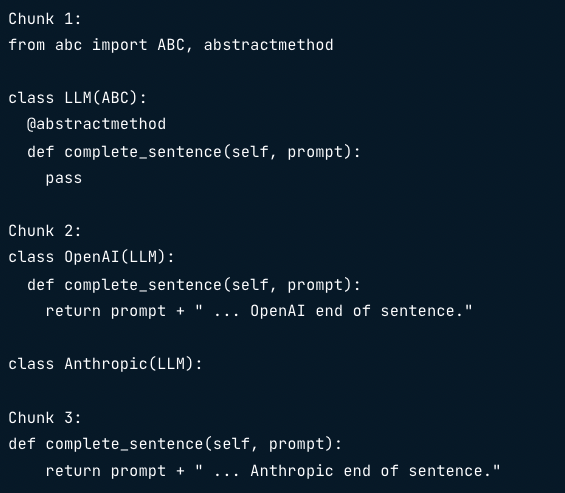

## Splitting by language

**separators**
- `["\n\n", "\n", " ", ""]`
- `["\nclass ", "\ndef", "\n\tdef", "\n\n", " ", ""]`

```python
from langchain_text_splitters import RecursiveCharacterTextSplitter, Language

python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=150, chunk_overlap=10
)

chunks = python_splitter.split_documents(data)

for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i+1}:\n{chunk.page_content}\n")
```

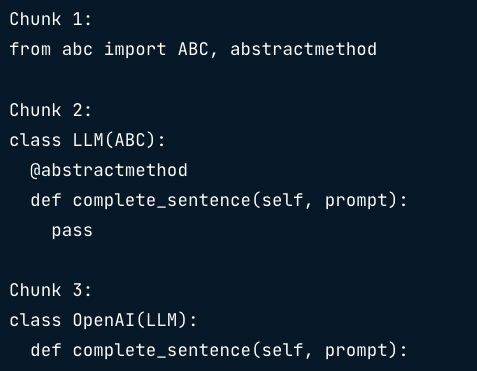



---
# Advanced splitting methods

## Limitations of our current splitting strategies

1. Splits are naive (not context-aware)
- Ignores context of surrounding text 

--> `SemanticChunker`

2. Splits are made using characters vs. tokens 
- Tokens are processed by models
- Risk exceeding the **context window**

--> `TokenTextSplitter`

## Splitting on tokens

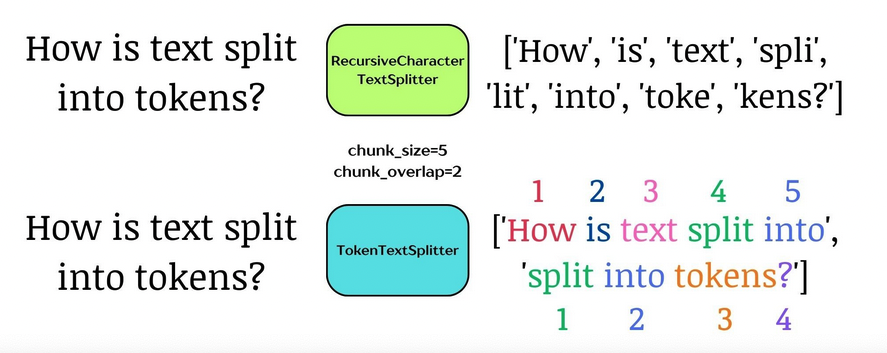

```python
import tiktoken
from langchain_text_splitters import TokenTextSplitter 

example_string = "Mary had a little lamb, it's fleece was white as snow."

encoding = tiktoken.encoding_for_model('gpt-4o-mini')
splitter = TokenTextSplitter(encoding_name=encoding.name,
                            chunk_size=10,
                            chunk_overlap=2)

chunks = splitter.split_text(example_string)

for i, chunk in enumerate(chunks):
    # Check if it was able to chunk 10 tokens
    print(f"Chunk {i+1}:\nNo. tokens: {len(encoding.encode(chunk))}\n{chunk}\n")
    print(f"Chunk {i+1}:\n{chunk}\n")
```

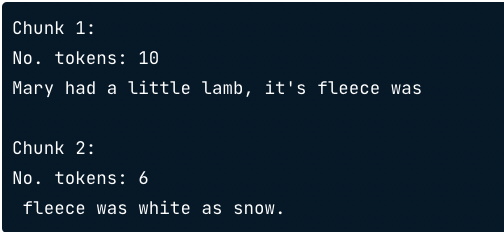

---
## Semantic splitting 

We need an embedding model to generate text embeddings to determine the shift in topic. 

```python
from langchain_openai import OpenAIEmbeddings
from langchain_experimental.text_splitter import SemanticChunker

embeddings = OpenAIEmbeddings(api_key="...", model="text-embedding-3-small")

semantic_splitter = SemanticChunker(
    embeddings=embeddings,
    breakpoint_threshold_type="gradient", # sets the metric at which embeddings are compared
    breakpoint_threshold_amount=0.8 # sets the metric's threshold at which to perform the split 
)

chunks = semantic_splitter.split_documents(data)
print(chunks[0])
```

---
# Optimizing document retrieval

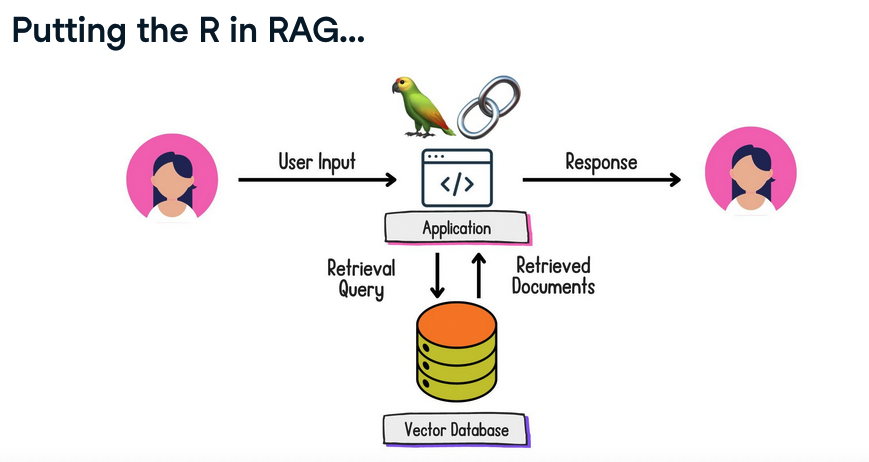

## Dense vs Sparse

`Dense` retrieval methods encode the entire chunk as a single vector that is said to be "dense", that is, most of its component values are `non-zero`. Dense retrieval excels at capturing semantic meaning, but the embeddings can be computationally intensive to create and query, and may struggle with capturing rare words or highly specific technical terms. 

`Sparse` retrieval is a method of finding information by matching specific keywords or terms in a query with those in documents. The resulting vectors contain many zeros, with only a few non-zero terms, which is why they are said to be "sparse". Sparse retrieval allows for precise retrieval, matching on exact words. The resulting vectors are also more explainable due to the alignment with specific terms, and rare words are better represented in the embeddings. The trade off is that sparse retreival is less generalizable, as they aren't extracting the semantic meaning from the text. 

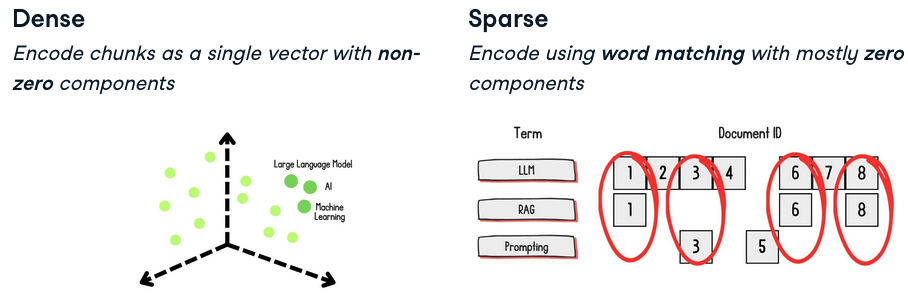

## Sparse retrieval methods

**TF-IDF** and **BM25** are the two popular methods for encoding text as sparse vectors. 

**TF-IDF**
- Creates a sparse vector that measures a term's frequency in a document and rarity in other documents. This helps in identifying words that best represent the document's unique content. 

**BM25**
- Improves on TF-IDF idea and prevents high-frequency words from being over-emphasized in the encoding. 

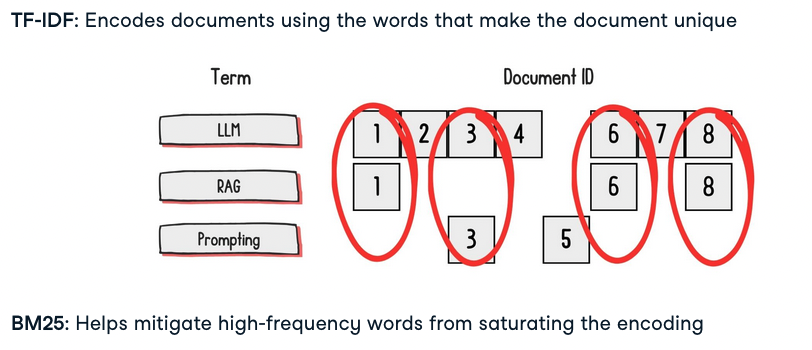

## BM25 retrieval

```python
from langchain_community.retrievers import BM25Retriever

chunks = [
    "Python was created by Guido van Rossum and released in 1991.",
    "Python is a popular language for machine learning (ML).",
    "The PyTorch library is a popular Python library for AI and ML."
]

bm25_retriever = BM25Retriever.from_texts(chunks, k=3)

results = bm25_retriever.invoke("When was Python created?")
print("Most Relevant Document:")
print(results[0].page_content)
```

## BM25 in RAG

```python
retriever = BM25Retriever.from_documents(
    documents=chunks,
    k=5
)

chain = ({"context": retriever, "question": RunnablePassthrough()}
         | prompt
         | llm
         | StrOutputParser()
        )

print(chain.invoke("How can LLM hallucination impact a RAG application?"))
```

---
# Introduction to RAG evaluation

Because RAG architecture is made up of several processes, there are a few places where performance can be measured. 
- Evaluate the retrieval process to check if the retrieved documents are relevant to the query
- Evaluate the generation process to see if the LLM hallucianted or misinterpreted the prompt
- Evaluate the final output to measure the performance of the whole system

![image.png](attachment:image.png)

## Output accuracy: string evaluation

We can use LLMs to measure the correctness of the final output by comparing it to a reference answer. 

```python
query = "What are the main components of RAG qrchitecture?"
predicted_answer = "Training and encoding"
ref_answer = "Retrieval and Generation"
```

To perform string evaluation, we need to define a prompt template and LLM to user for evaluation. 

```python
prompt_template = """You are an expert professor specialized in grading students' answer
You are grading the following question: {query}
Here is the real answer": {answer}
You are grading the following predicted answer: {result}
Respond with CORRECT or INCORRECT:
Grade:"""

prompt = PromptTemplate(
    input_variables=["query", "answer", "result"],
    template=prompt_template
)

eval_llm = ChatOpenAI(temperature=0, model="gpt-4o-mini", openai_api_key='...')
# temperature is set to 0 to minimize variability

from langsmith.evaluation import LangChainStringEvaluator

qa_evaluator = LangChainStringEvaluator(
    "qa",
    config={
        "llm": eval_llm,
        "prompt": PROMPT
    }
)

score = qa_evaluator.evaluator.evaluate_strings(
    prediction=predicted_answer,
    reference=ref_answer,
    input=query
)

print(f"Score: {score}")
```

## Ragas framework

![image-2.png](attachment:image-2.png)

### Faithfulness

`Does the generated output faithfully represent the context?`

![image-3.png](attachment:image-3.png)

```python
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.integrations.langchain import EvaluatorChain
from ragas.metrics import faithfulness

llm = ChatOpenAI(model="gpt-4o-mini", api_key="...")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key="...")

faithfulness_chain = EvaluatorChain(
    metric=faithfulness,
    llm=llm,
    embeddings=embeddings
)

eval_result = faithfulness_chain({
    "question": "How does the RAG model improve question answering with LLMs?",
    "answer": "The RAG model improves question answering by combining the retrieval of documents...",
    "contexts": [
        "The RAG model integrates document retrieval with LLMs by first retrieving relevant passages...",
        "By incorporating retrieval mechanisms, RAG leverages external knowledge sources, allowing the ..."
    ]
})

print(eval_result)
```

### Context precision

`How relevant are the retrieved documents to the query?`

```python
from ragas.metrics import context_precision

llm = ChatOpenAI(model="gpt-4o-mini", api_key="...")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key="...")

context_precision_chain = EvaluatorChain(
    metric=context_precision,
    llm=llm,
    embeddings=embeddings
)

eval_result = context_precision_chain({
    "question": "How does the RAG model improve question answering with LLMs?",
    "ground_truth": "The RAG model improves question answering by combining the retrieval of documents...",
    "contexts": [
        "The RAG model integrates document retrieval with LLMs by first retrieving relevant passages...",
        "By incorporating retrieval mechanisms, RAG leverages external knowledge sources, allowing the ..."
    ]
})

print(f"Context Precision: {eval_result['context_precision']}")
```

---
## Exercises

![image-4.png](attachment:image-4.png)

---
# 3. Introduction to Graph RAG

---
# From vectors to graphs

**`Neo4j` graph database**

## Loading and chunking Wikipedia pages

```python
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import TokenTextSplitter

raw_documents = WikipediaLoader(query="large language model").load()
text_splitter = TokenTextSplitter(chunk_size=100, chunk_overlap=20)
documents = text_splitter.split_documents(raw_documents[:3])

print(documents[0])
```

## From text to graphs!

We begin by defining the LLM to use for the transformation, and use it to create an LLMGraphTransformer. 

Note that we use `temperature=0` to produce more deterministic graphs for greater reliability. 

The LLM creates structured graph documents by parsing and categorizing entities and their relationships, which it infers from the documents. 

```python
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm = ChatOpenAI(api_key="...", temperature=0, model_name="gpt-4o-mini")
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(graph_documents)
```

---
# Storing and querying documents

## Instantiating the Neo4j database

```python
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(url="bolt://localhost:7687", username="neo4j", password="...")

import os

url = os.environ["NEO4J_URI"]
user = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]

graph = Neo4jGraph(url=url, username=user, password=password)
```

## Strong graph documents

```python
from langchain_experimental.graph_transformers import LLMGraphTransformer

llm = ChatOpenAI(api_key="...", temperature=0, model="gpt-4o-mini")
llm_transformer = LLMGraphTransformer(llm=llm)

graph_documents = llm_transformer.convert_to_graph_documents(documents)

graph.add_graph_documents(
    graph_documents,
    include_source=True, # link nodes to source documents with `MENTIONS` edge
    baseEntityLabel=True # add `__Entity__` label to each node
)
```

## Database schema

```python
print(graph.get_schema)
```
![image.png](attachment:image.png)

## Querying Neo4j - Cypher Query Language

![image-3.png](attachment:image-3.png)

## Querying the LLM graph

```python
results = graph.query("""
MATCH (gpt4:Model {id: "Gpt-4"})-[:DEVELOPED_BY]->(org:Organization)
RETURN org
""")

print(results)
```
`[{'org': {'id': 'Openai'}}]`

---
# Creating the Graph RAG chain

![image-2.png](attachment:image-2.png)

![image-3.png](attachment:image-3.png)

## Querying the graph

```python
from langchain_community.chains.graph_qa.cypher import GraphCypherQAChain

chain = GraphCypherQAChain.from_llm(
    llm=ChatOpenAI(api_key="...", temperature=0), graph=graph, verbose=True
)

result = chain.invoke({"query": "What is the most accurate model?"})

print(f"Final answer: {result['result']}")
```

![image-4.png](attachment:image-4.png)

## Customization

```python
chain = GraphCypherQAChain.from_llm(
    llm=ChatOpenAI(api_key="...", temperature=0), graph=graph, verbose=True
)
```

- `qa_prompt`: prompt template for result generation
- `cypher_prompt`: prompt template for Cypher generation
- `cypher_llm`: LLM for Cypher generation
- `qa_llm`: LLM for result generation 

---
# Improving graph retrieval

**Main limitation:** reliability of user -> Cypher translation

**Strategies to improve graph retrieval system:**
- Filtering Graph Schema
- Validating the Cypher Query
- Few-shot prompting 

## Filtering

Removing unneeded properties from the schema so the model can focus on specific subset and improve Cypher query

```python
from langchain_community.chains.graph_qa.cypher import GraphCypherQAChain

llm = ChatOpenAI(api_key="...", model="gpt-4o-mini", temperature=0)

chain = GraphCypherQAChain.from_llm(
    graph=graph, llm=llm, exclude_types=["Concept"], verbose=True
)

# Invoke the chain with the input provided
result = chain.invoke({"query": "..."})
print(f"Final answr: {result['result']}")

print(graph.get_schema)
```

## Validating the Cypher query

`LLM has difficulty in interpreting the direction of relationships`

```python
chain = GraphCypherQAChain.from_llm(
    graph=graph, llm=llm, verbose=True, validate_cypher=True
)
```

- Detects nodes and relationships
- Determines the directions of the relationship
- Checks the graph schema
- Update the direction of relationships 

## Few-shot prompting

```python
examples = [
    {
        "question": "How many notable large language models are mentioned in the article?",
        "query": "MATCH (m:Concept {id: 'Large Language Model'}) RETURN count(DISTINCT m)"
    },
    {
        "question": "Which companies or organizations have developed the large language models mentioned?",
        "query": "MATCH (o:Organization)-[:DEVELOPS]->(m:Concept {id: 'Large Language Model'}) RETURN DISTINCT o.id",
    },
    {
        "question": "What is the largest model size mentioned in the article, in terms of number of parameters?",
        "query": "MATCH (m:Concept {id: 'Large Language Model'}) RETURN max(m.parameters) AS largest_model",
    }
]

```

## Implementing few-shot prompting
```python
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate

example_prompt = PromptTemplate.from_template(
    "User input: {question}\nCypher query: {query}"
)

cypher_prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix="You are a Neo4j expert. Given an input question, create a syntactically correct \n
    Cypher query to run. \n\nHere is the schema information\n{schema}. \n\n \n
    Below are a number of examples of questions and their corresponding Cypher queries.",
    suffix="User input: {question}\nCypher query: ",
    input_variables=["question"],
)
```

## Adding the few-shot examples

```python
chain = GraphCypherQAChain.from_llm(
    graph=graph, llm=llm, cypher_prompt=cypher_prompt,
    verbose=True, validate_cypher=True
)
```